In [1]:
import os
import glob
import pickle
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from joblib import dump, load

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.model_selection import GridSearchCV

from acea.model_evaluation import evaluation_metrics, model_evaluation_plots
from acea.models import BaseModel
from acea.report import create_latex_score_summary
from acea.data_loaders import get_batch
from acea.model_training import batch_training

%matplotlib inline

In [2]:
FORECAST_PERIOD = 60
TEST_PERIOD = 30
TRAIN_PERIOD = 730

In [3]:
def load_data(files):
    
    # initiate dict to store data
    dfs = {}

    for f in files:

        # get name of the water body from the filename
        database = f.split('\\')[-1].replace('.csv','')
    
        # load the data
        df = pd.read_csv(f)

        # get start and end data of the data
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])

        # store data in dictionary by water body name
        dfs[database] = df
    
    return dfs

In [4]:
def get_batch(df):
    # note: forecast horizon is taken into account in feature engineering: features are  moved backwards with 
    # forecast_period!
    n = int(np.floor((len(df) - TRAIN_PERIOD - FORECAST_PERIOD)/TEST_PERIOD))
    for i in range(n):
        train_start = i*TEST_PERIOD
        train_end   = train_start + TRAIN_PERIOD
        test_end  = train_end + TEST_PERIOD
        yield list(range(train_start, train_end)), list(range(train_end, test_end)) 
        
def get_custom_batch(df, train_period, test_period):
    n = int(np.floor((len(df)-train_period- FORECAST_PERIOD)/test_period))
    for i in range(n):
        train_start = i*test_period
        train_end   = train_start + train_period
        test_end  = train_end + test_period
        yield list(range(train_start, train_end)), list(range(train_end, test_end)) 


In [5]:


def get_list_of_files(dfbest):
    best_data = []

    for i, row in dfbest.iterrows():

        method = row['method']
        name = row['name']
        if method == 'manual':
            tmp_path = os.path.join(datadir, 'feats', 'D%d'%FORECAST_PERIOD, method) 
        else:
            tmp_path = os.path.join(datadir, 'feats', 'D%d'%FORECAST_PERIOD, 'automatic', method) 

        filename = os.path.join(tmp_path, '%s.csv'%name)

        #best_data[name] = filename
        best_data.append(filename)
    return best_data

In [6]:
def get_time_diff(t0, t1):
    
    hours = int(np.floor((t1-t0)/3600))
    minutes = int(np.floor(((t1-t0) - hours*3600)/60))
    seconds = int((t1-t0) - hours*3600 - minutes*60)
    
    timing = '%2d:%2d:%2d'%(hours, minutes, seconds)
    timing = timing.replace(' ', '0')
    
    return timing
    
    
    

In [7]:
def create_best_params_overview(best_params):
    
    names = best_params.keys()
    
    tmp = []
    for name in names:
        tmp.append(best_params[name])

    dfres = pd.DataFrame().from_records(tmp)
    dfres = dfres.rename(columns=lambda x: x.split('__')[-1]).replace(np.nan, '')

    dfres['water body'] = [' '.join(n.split('_')[:2]) for n in names]
    dfres['target'] = [' '.join(n.split('_')[2:]) for n in names]

    dfres['Regressor'] = dfbest['reg_name']

    cols = ['water body',
           'target', 'Regressor','learning_rate', 'loss', 'n_estimators', 'C', 'kernel',
           'early_stopping', 'hidden_layer_sizes', 'learning_rate',
           'learning_rate_init', 'max_iter', 'solver']

    return dfres[cols].T

# Settings

In [8]:
model_sel_metric = 'rmse'

datadir = '../data'
modeldir = '../models/D%d'%FORECAST_PERIOD

filename_model_features = 'results/D%s_best_models_and_features_%s.csv'%(FORECAST_PERIOD, model_sel_metric)

# Load data

In [9]:
dfbest = pd.read_csv(filename_model_features)

files = get_list_of_files(dfbest)
dfs = load_data(files)

names = list(dfs.keys())

best_params = pickle.load(open('../models/D%d/best_params.p'%FORECAST_PERIOD, 'rb'))

names

['Aquifer_Auser_Depth_to_Groundwater_COS',
 'Aquifer_Auser_Depth_to_Groundwater_LT2',
 'Aquifer_Auser_Depth_to_Groundwater_SAL',
 'Aquifer_Petrignano_Depth_to_Groundwater_P24',
 'Aquifer_Petrignano_Depth_to_Groundwater_P25',
 'Lake_Bilancino_Flow_Rate',
 'Lake_Bilancino_Lake_Level',
 'River_Arno_Hydrometry_Nave_di_Rosano']

# Model settings

In [10]:
reg_names = ['NeuralNetwork', 
             'SVM', 
             'GradientBoosting' 
             ]

regressors = {'NeuralNetwork': MLPRegressor(),
              'SVM': SVR(),
              'GradientBoosting': GradientBoostingRegressor(criterion='mse')
             }

params_nn = {'mlpregressor__hidden_layer_sizes' : [(100,), (200, 100)],
             'mlpregressor__solver': ['sgd','adam'],
             'mlpregressor__learning_rate': ['constant'],
             'mlpregressor__learning_rate_init': [0.001, 0.0001],
             'mlpregressor__max_iter': [400, 800],
             'mlpregressor__early_stopping': [True]}


params_gb = {'gradientboostingregressor__loss': ['ls', 'huber', 'lad'],
             'gradientboostingregressor__n_estimators': [100, 200, 300],
             'gradientboostingregressor__learning_rate': [0.1, 0.05]}

params_svr = {'svr__kernel': ['linear', 'poly', 'rbf','sigmoid'],
              'svr__C': [0.1, 1, 10]}

params = {'NeuralNetwork': params_nn,
          'SVM': params_svr,
          'GradientBoosting': params_gb}

# Train final model with best parameters

In [11]:
dfbest

,metric,reg_name,mean,std,method,name
0,rmse,GradientBoosting,0.303455,0.511532,pearson,Aquifer_Auser_Depth_to_Groundwater_COS
1,rmse,NeuralNetwork,0.023001,0.020563,phik,Aquifer_Auser_Depth_to_Groundwater_LT2
2,rmse,SVM,0.113858,0.217154,phik,Aquifer_Auser_Depth_to_Groundwater_SAL
3,rmse,SVM,0.398188,0.279222,phik,Aquifer_Petrignano_Depth_to_Groundwater_P24
4,rmse,SVM,0.251103,0.232212,phik,Aquifer_Petrignano_Depth_to_Groundwater_P25
5,rmse,NeuralNetwork,12.880070,25.963930,manual,Lake_Bilancino_Flow_Rate
6,rmse,SVM,0.920202,1.077469,phik,Lake_Bilancino_Lake_Level
7,rmse,SVM,0.299538,0.374103,manual,River_Arno_Hydrometry_Nave_di_Rosano


In [23]:
best_model_scores = {}

for name in names:
    
    print('#', name)
    
    params = best_params[name]
    reg_name = dfbest.set_index('name').loc[name, 'reg_name']
    
    # get data
    df = dfs[name].copy()
           
    y = df.drop(columns='Date').iloc[-(TRAIN_PERIOD+TEST_PERIOD):-TEST_PERIOD,[0]].values
    X = df.drop(columns='Date').iloc[-(TRAIN_PERIOD+TEST_PERIOD):-TEST_PERIOD, 1:].values
    
    y = y.ravel()
    
    columns = {'target': df.drop(columns='Date').iloc[:,[0]].columns,
               'features': df.drop(columns='Date').iloc[:, 1:].columns}
    
    dates = df['Date'].values

    if reg_name == 'GradientBoosting':

        learning_rate = params['gradientboostingregressor__learning_rate']
        loss = params['gradientboostingregressor__loss']
        n_estimators = params['gradientboostingregressor__n_estimators']
        
        regressor = GradientBoostingRegressor(learning_rate=learning_rate, loss=loss, n_estimators=n_estimators)  
            
    elif reg_name == 'NeuralNetwork':
        
        early_stopping = params['mlpregressor__early_stopping']
        hidden_layer_sizes = params['mlpregressor__hidden_layer_sizes']
        learning_rate = params['mlpregressor__learning_rate']
        learning_rate_init = params['mlpregressor__learning_rate_init']
        max_iter = params['mlpregressor__max_iter']
        solver = params['mlpregressor__solver']
    
        regressor = MLPRegressor(learning_rate=learning_rate, learning_rate_init=learning_rate_init, 
                                    hidden_layer_sizes=hidden_layer_sizes, early_stopping=early_stopping, 
                                   max_iter=max_iter, solver=solver)
        
    elif reg_name == 'SVM':
        
        C = params['svr__C']
        kernel = params['svr__kernel']
        
        regressor = SVR(C=C, kernel=kernel)
        
    else:
        raise('Regressor not implemented', reg_name)
        
    regressor.fit(X, y)
    
    
    dump(regressor, os.path.join(modeldir,'model_%s.joblib'%name))
    dump(columns, os.path.join(modeldir, 'features_%s.joblib'%name))
    

# Aquifer_Auser_Depth_to_Groundwater_COS
# Aquifer_Auser_Depth_to_Groundwater_LT2
# Aquifer_Auser_Depth_to_Groundwater_SAL
# Aquifer_Petrignano_Depth_to_Groundwater_P24
# Aquifer_Petrignano_Depth_to_Groundwater_P25
# Lake_Bilancino_Flow_Rate
# Lake_Bilancino_Lake_Level
# River_Arno_Hydrometry_Nave_di_Rosano


### create summary table for best model

In [169]:
best_summary = {}
for name in names:
    best_summary[name] = pd.DataFrame(best_model_scores[name]).agg(['mean', 'std']).T

In [170]:
print(create_latex_score_summary(names, best_summary))

\begin{tabular}{lllll}
\toprule
{} &                       r2 &                 rmse &                mae &               mape \\
\midrule
Aquifer\_Auser\_Depth\_to\_Groundwater\_COS      &       $ -3.72 \pm 6.27 $ &    $ 0.28 \pm 0.52 $ &  $ 0.38 \pm 0.33 $ &  $ 0.07 \pm 0.07 $ \\
Aquifer\_Auser\_Depth\_to\_Groundwater\_LT2      &      $ -7.61 \pm 11.02 $ &    $ 0.03 \pm 0.03 $ &  $ 0.12 \pm 0.07 $ &  $ 0.01 \pm 0.01 $ \\
Aquifer\_Auser\_Depth\_to\_Groundwater\_SAL      &     $ -11.46 \pm 24.06 $ &    $ 0.11 \pm 0.22 $ &  $ 0.24 \pm 0.19 $ &  $ 0.05 \pm 0.05 $ \\
Aquifer\_Petrignano\_Depth\_to\_Groundwater\_P24 &      $ -9.59 \pm 12.50 $ &    $ 0.42 \pm 0.38 $ &  $ 0.54 \pm 0.27 $ &  $ 0.02 \pm 0.01 $ \\
Aquifer\_Petrignano\_Depth\_to\_Groundwater\_P25 &     $ -11.06 \pm 12.14 $ &    $ 0.25 \pm 0.23 $ &  $ 0.41 \pm 0.22 $ &  $ 0.02 \pm 0.01 $ \\
Lake\_Bilancino\_Flow\_Rate                    &         $ -inf \pm inf $ &  $ 12.77 \pm 28.14 $ &  $ 1.94 \pm 2.13 $ &  $ 1.41 \pm 1.53 $ \\

# Train base model and get evaluation metrics

- note: time period used for training/testing/validation has changed, compared to notebook 6

# Aquifer_Auser_Depth_to_Groundwater_COS
# Aquifer_Auser_Depth_to_Groundwater_LT2
# Aquifer_Auser_Depth_to_Groundwater_SAL
# Aquifer_Petrignano_Depth_to_Groundwater_P24
# Aquifer_Petrignano_Depth_to_Groundwater_P25
# Lake_Bilancino_Flow_Rate
# Lake_Bilancino_Lake_Level
# River_Arno_Hydrometry_Nave_di_Rosano


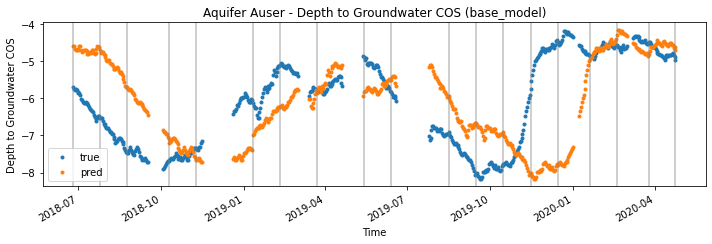

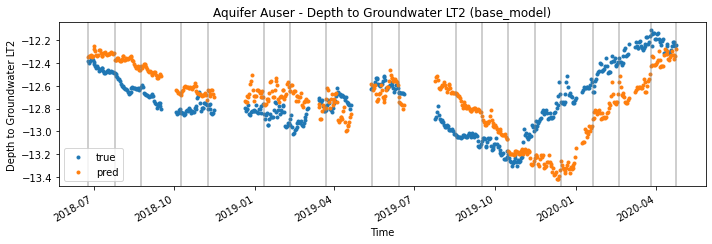

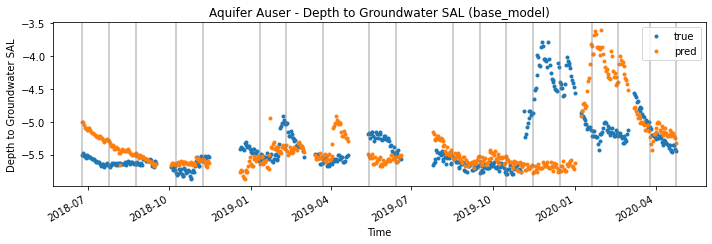

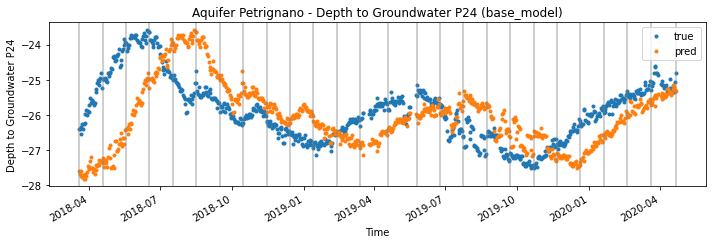

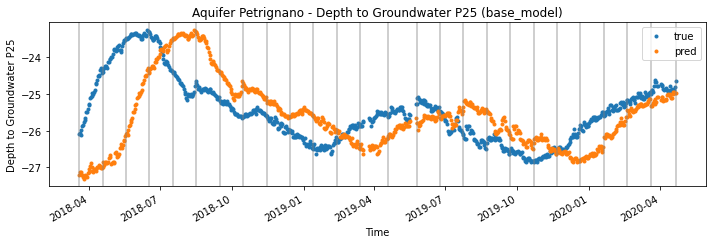

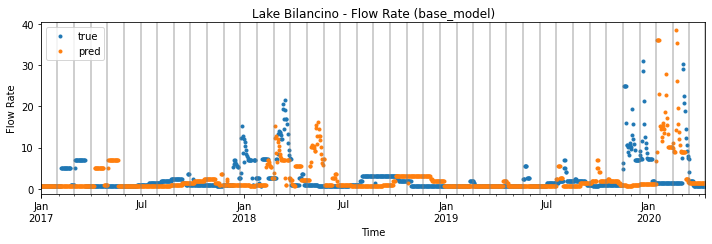

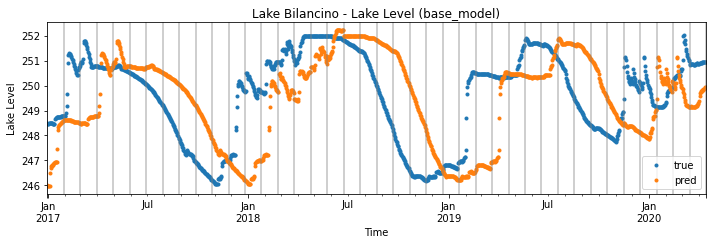

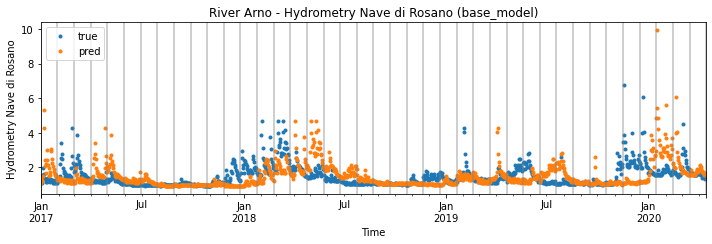

In [134]:
base_model_scores = {}

for name in names:
    
    print('#', name)
    
    # get data
    df = dfsb[name].copy()
    
    # limit the data to somewhat recent years
    if 'Date' in df.columns:
        df = df[df['Date']>='2015-01-01']
    else:
        df = df.loc['2015-01-01':]
        
    batches = get_batch(df)
    
    y = df.drop(columns='Date').iloc[:,[0]].values
    X = df.drop(columns='Date').iloc[:,1:].values
    
    dates = df['Date'].values

    regressor = BaseModel()
    
    scores = batch_training(X, y, dates, regressor, 'base_model', name=name)
    
    base_model_scores[name] = scores
    
    

### create summary table for base model

In [151]:
base_summary = {}
for name in names:
    base_summary[name] = pd.DataFrame(base_model_scores[name]).agg(['mean', 'std']).T

In [168]:
print(create_latex_score_summary(names, base_summary))

\begin{tabular}{lllll}
\toprule
{} &                        r2 &                 rmse &                mae &               mape \\
\midrule
Aquifer\_Auser\_Depth\_to\_Groundwater\_COS      &      $ -30.02 \pm 43.97 $ &    $ 1.78 \pm 2.61 $ &  $ 1.01 \pm 0.80 $ &  $ 0.18 \pm 0.17 $ \\
Aquifer\_Auser\_Depth\_to\_Groundwater\_LT2      &      $ -18.34 \pm 19.13 $ &    $ 0.07 \pm 0.08 $ &  $ 0.23 \pm 0.12 $ &  $ 0.02 \pm 0.01 $ \\
Aquifer\_Auser\_Depth\_to\_Groundwater\_SAL      &      $ -24.63 \pm 45.97 $ &    $ 0.34 \pm 0.62 $ &  $ 0.38 \pm 0.40 $ &  $ 0.08 \pm 0.09 $ \\
Aquifer\_Petrignano\_Depth\_to\_Groundwater\_P24 &      $ -22.69 \pm 33.40 $ &    $ 1.05 \pm 1.46 $ &  $ 0.82 \pm 0.55 $ &  $ 0.03 \pm 0.02 $ \\
Aquifer\_Petrignano\_Depth\_to\_Groundwater\_P25 &     $ -62.19 \pm 170.06 $ &    $ 1.00 \pm 1.70 $ &  $ 0.77 \pm 0.61 $ &  $ 0.03 \pm 0.03 $ \\
Lake\_Bilancino\_Flow\_Rate                    &          $ -inf \pm inf $ &  $ 28.94 \pm 64.93 $ &  $ 2.84 \pm 3.59 $ &  $ 1.68 \pm 2.